# Have a second look at the spatial correlation between isopycnal depth time series and the ekman transport at large

## First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [1]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Loading the basics

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [3]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39249/status,
Dashboard: /proxy/39249/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42169,Workers: 7
Dashboard: /proxy/39249/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:41347,Total threads: 2
Dashboard: /proxy/39175/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:36295,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### Creating variables for time series

### temperature

In [5]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)


In [6]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

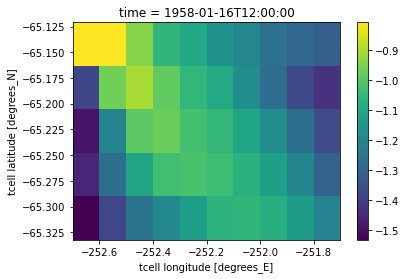

In [7]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [8]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [9]:
temp_400m = temp_400m.load()

#### Detrend time series and apply rolling mean 

In [10]:
# Note we need to first detrend the data:
temp_400m_zadr = detrend_dim(temp_400m,'time')
temp_400m_zadr = temp_400m_zadr.rolling(time=12, center=True).mean()
temp_400m_r = temp_400m.rolling(time=12, center=True).mean()

#### ISOPYCNALS 
##### Cut data loaded on previously, so we don't have t load it again

In [11]:
# ORIGINAL
lon_slice  = slice(-253, -251.5)
lat_slice  = slice(-67.5, -63)

temp_iso = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

sal_iso = cc.querying.getvar(iaf_cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [12]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

In [13]:
# cut the data BOX 1
#lon_slice  = slice(-253, -251.5) #best
lat_slice  = slice(-65.3, -63)
lon_slice  = slice(-253.5, -251.1)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

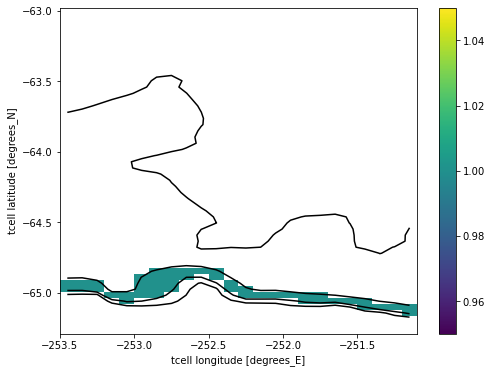

In [14]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [15]:
#apply the mask
sigma0_off = sigma0*region_mask
sigma0_off = sigma0_off.where(sigma0_off!=0)

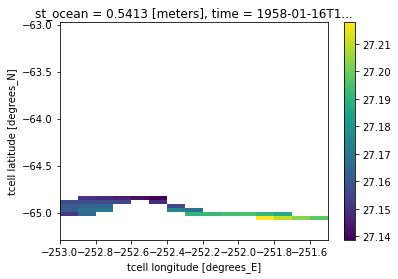

In [16]:
# first time step only:
sigma0_off[0,0,...].plot()

In [17]:
#load
sigma0_off=sigma0_off.load()

Incorporating Adele's method of calculating isopycnals.
Old method works fine, but averaging across lat/lon first means that your final depth values will be limited to values of st_ocean (i.e. quite discrete and widely spaced).
Try to find first depth where density > rho_thresh (27.82 looks like it might be around 500-600 m, i.e. at the depth of shelf break) at each lat/lon position, then average these depths after over lat/lon, which should make the final depth values have more variable values.

Using only the isopycnals that had the highest correlations with previous variables 27.82 and 27.83

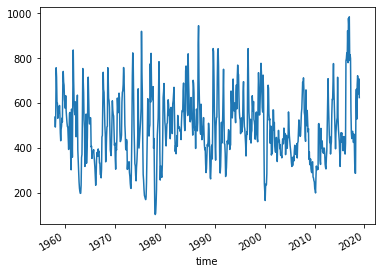

In [18]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0_off.where(sigma0_off>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0_off*0 + sigma0_off.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0_off>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

# now average that minimum depth over lat and lon:
min_depth_avg = min_depth.mean('xt_ocean').mean('yt_ocean')
min_depth_avg.plot()

#rename the isopycnal
iso2782_dth=min_depth_avg

In [19]:
#they are still xarrays until I load them
iso2782_dth=iso2782_dth.load()


### Apply rolling mean 

In [20]:
iso2782_dth_r = iso2782_dth.rolling(time=12, center=True).mean()


## LOAD SPEED

### ASC SPEED USING TRANSECT LINE

In [21]:
# depth limits chosen based on transects
depth_slice = slice(200, 500)
# set this to the rough region of interest:
#lat_slice  = slice(-65.5,-65.4)
#lat_slice  = -65
lat_slice  = slice(-66, -63)
lon_slice  = slice(-255, -248)
#get U general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)


In [22]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
u_slice = u_speed.sel(st_ocean=400,method='nearest').mean('time')
u_slice = u_slice.load()

# also get bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
ht = ht.load()

In [23]:
u_slice

<xarray.DataArray 'u' (yu_ocean: 69, xu_ocean: 70)>
array([[ 0.00510614,  0.00146219, -0.00411599, ...,         nan,
                nan,         nan],
       [        nan,  0.00144473, -0.00422724, ...,         nan,
                nan,         nan],
       [        nan,  0.00359363, -0.00176692, ...,         nan,
                nan,         nan],
       ...,
       [-0.02645123, -0.0253588 , -0.02215718, ...,  0.03076813,
         0.03060459,  0.029538  ],
       [-0.02567865, -0.02534202, -0.02281484, ...,  0.02995209,
         0.02944377,  0.02830261],
       [-0.02163104, -0.02200456, -0.01986072, ...,  0.029411  ,
         0.02885071,  0.02749652]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -255.0 -254.9 -254.8 ... -248.3 -248.2 -248.1
  * yu_ocean  (yu_ocean) float64 -65.97 -65.92 -65.88 ... -63.11 -63.07 -63.02
    st_ocean  float64 383.0

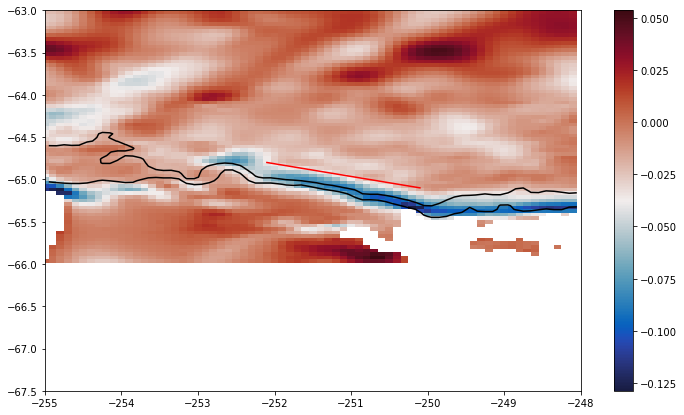

In [24]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -64.8 #64.8
lat1= -65.1 #65.1
lon0 = -252.1 #252.1
lon1 = -250.1 #250.1

plt.figure(figsize=(12,7))

# plot temperature:
plt.pcolormesh(u_slice.xu_ocean,u_slice.yu_ocean,u_slice, cmap=cmocean.balance)#,
#              vmin=-2,vmax=1)
plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')
plt.xlim((-255, -248))
plt.ylim((-67.5, -63))
# plot bathymetry contours:
i=plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000],colors='k')

#save_results_to = '/g/data/jk72/ns3783/Round8'
#plt.savefig(save_results_to + 'transect_lat_IAF3.png', dpi=120,bbox_inches='tight', pad_inches=0.1)
#plt.savefig(save_results_to + 'transect_asc_trajectory+temp.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

In [25]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
lons = [lon0, lon1]
lats = [lat0, lat1]

yu_ocean = u_speed.yu_ocean


# get latitude of points along transect:
lat_transect = yu_ocean.sel(yu_ocean = slice(lats[1],lats[0])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yu_ocean')

# Extract temp and salt along transect:
u_transect = u_speed.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')

u_transect = u_transect.load()

In [26]:
#u_transect

In [27]:
u_transect=u_transect.mean('yu_ocean').mean('st_ocean')

#### Detrend time series both ASC heat flux X and speed time series

In [28]:
#asc_X_d = detrend_dim(asc_heat_x,'time')
u_speed_td = detrend_dim(u_transect,'time')

#### Apply Rolling mean to them 

In [29]:
#asc_X_dr = asc_X_d.rolling(time=12, center=True).mean()
u_speed_tdr = u_speed_td.rolling(time=12, center=True).mean()

In [30]:
u_speed_tr = u_transect.rolling(time=12, center=True).mean()

## LOAD EKMAN TO CALCULATE BOTH SPATIAL CORRELATION

In [31]:
#tem que repetir aqui a lat pq esta interferindo no tamanho da matriz no final d calculo
#lon_slice  = slice(-252.5, -250.5) # best for time series
#lat_slice  = slice(-67.5, -63) best for time series

lon_slice  = slice(-256, -240) 
lat_slice  = slice(-67,-63) 


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [32]:
# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -240) 
lat_slice  = slice(-67,-63) 

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [33]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

In [34]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [35]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day

# mask land:
ekman_con = ekman_con.where(ekman_con!=0)

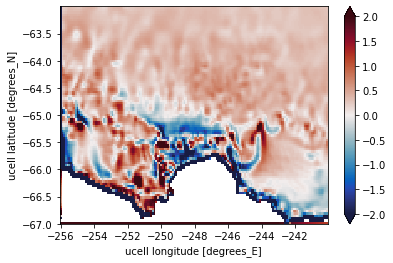

In [36]:
# quick check that this looks ok:
ekman_con.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

In [37]:
ekman_con=ekman_con.load()

### Climatology 

In [38]:
# calculate monthly climatology
climatology = ekman_con.groupby('time.month').mean('time')

# remove seasonal signal
ekman_con_seasonal_removed = (ekman_con - climatology)

In [39]:
#ekman_con_seasonal_removed

In [40]:
## this helps to check which months are contained on our main data files. 
month=ekman_con['time.month'].values


In [41]:
#load the variable
ekman_con_seasonal_removed = ekman_con_seasonal_removed.load()
##test
#np.amin(temp_400m_za)

In [42]:
# select a single month and drop the 'month' dimension
ekman_con_seasonal_removed = ekman_con_seasonal_removed.isel(month=0).drop('month')

In [43]:
# Note we need to first detrend the data:
#ekman_con_detrended = detrend_dim(ekman_con_seasonal_removed,'time') #commented out because if we run this line the average panel is 0. 
ekman_con_dr = ekman_con_seasonal_removed.rolling(time=12, center=True).mean()

### compute correlation

In [105]:
# This computes the cor: era lax=2
cov,cor_ekman,slope,intercept,pval_iso,stderr = lag_linregress_3D(iso2782_dth_r,ekman_con_dr,lagx=2, lagy=0)

In [106]:
# This computes the cor: era lag x=6
cov,cor_temp,slope,intercept,pval_temp,stderr = lag_linregress_3D(temp_400m_zadr,ekman_con_dr,lagx=2, lagy=0)


In [107]:
# This computes the cor:
cov,cor_asc,slope,intercept,pval_asc,stderr = lag_linregress_3D(u_speed_tr,ekman_con_dr,lagx=7, lagy=0)

## Compute significance accounting for autocorrelation:

#### isopynal hatch

In [113]:
## this is the cell from Adele's code for reference on how to adapt the two cells below
# Manually shift by 2 years, I don't think the lag in the code above is working:
#cov,temp_SWMT_correlation,temp_SWMT_slope,intercept,pval,stderr = lag_linregress_3D(rolling_mean_timeseries_IAF[2:-2].shift(year=2),temp_IAF_detrended)


In [114]:
temp_SWMT_correlation=cor_ekman

# autocorrelation of spatial map of temperature:
cov,temp_autocorrelation,slope,intercept,pval,stderr = lag_linregress_3D(ekman_con_dr,ekman_con_dr)

# autocorrelation of SWMT:
cov,SWMT_autocorrelation,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dth_r.shift(time=2),iso2782_dth_r)

# original sample size:
N = len(iso2782_dth_r)
    
# effective sample size for each lat/long location:
N_eff = N*(1-temp_autocorrelation*SWMT_autocorrelation)/(1+temp_autocorrelation*SWMT_autocorrelation)
N_eff = N_eff.load()

# compute t-statistic:
t_statistic = temp_SWMT_correlation*np.sqrt(N_eff)/(np.sqrt(1-temp_SWMT_correlation*temp_SWMT_correlation))
t_statistic = t_statistic.load()


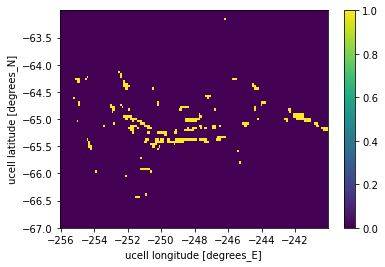

In [102]:
# I've used degrees of freedom = N_eff - 1.

# values from two-tailed t-distribution table:

# where N_eff < 6, critical value is 2.8, mask where t-statistic < 2.8
# where 6 < N_eff < 7, critical value is 2.6, mask where t-statistic < 2.6
# where 7 < N_eff < 8, critical value is 2.5, mask where t-statistic < 2.5
# where 8 < N_eff < 9, critical value is 2.4, mask where t-statistic < 2.4
# where 9 < N_eff < 11, critical value is 2.3, mask where t-statistic < 2.3
# where 11 < N_eff < 15, critical value is 2.2, mask where t-statistic < 2.2
# where 15 < N_eff < 29, critical value is 2.1, mask where t-statistic < 2.1
# where 29 < N_eff , critical value is 2.0, mask where t-statistic < 2.0

def compute_significance_mask(N_eff,t_statistic):
    ones = N_eff*0+1
    Neff6 = ones.where(N_eff<6,other=0).where(np.abs(t_statistic)>2.8,other=0)
    Neff7 = ones.where(N_eff>6,other=0).where(N_eff<7,other=0).where(np.abs(t_statistic)>2.6,other=0)
    Neff8 = ones.where(N_eff>7,other=0).where(N_eff<8,other=0).where(np.abs(t_statistic)>2.5,other=0)
    Neff9 = ones.where(N_eff>8,other=0).where(N_eff<9,other=0).where(np.abs(t_statistic)>2.4,other=0)
    Neff10 = ones.where(N_eff>9,other=0).where(N_eff<11,other=0).where(np.abs(t_statistic)>2.3,other=0)
    Neff11 = ones.where(N_eff>11,other=0).where(N_eff<15,other=0).where(np.abs(t_statistic)>2.2,other=0)
    Neff15 = ones.where(N_eff>15,other=0).where(N_eff<29,other=0).where(np.abs(t_statistic)>2.1,other=0)
    Neff29 = ones.where(N_eff>29,other=0).where(np.abs(t_statistic)>2.0,other=0)
    
    significance = Neff6 + Neff7 + Neff8 +  Neff9 + Neff10 + Neff11 + Neff15 + Neff29
    
    return(significance)

significance = compute_significance_mask(N_eff,t_statistic)
significance.plot()
significance = significance.load()

In [103]:
t_statistic_ek = t_statistic
significance_ek = significance


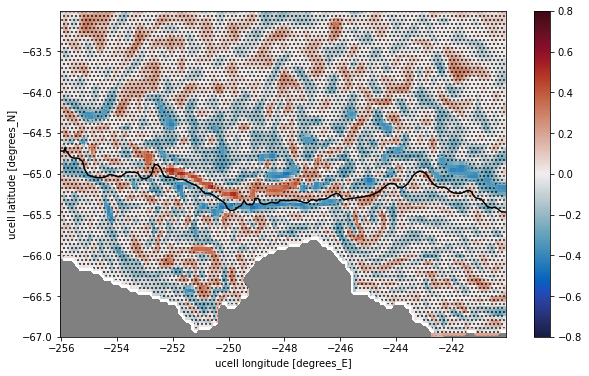

In [104]:
fig = plt.figure(figsize=(10,6))

cor_ekman.plot(vmin=-.8,vmax=.8,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

# hatching where not significant:
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'k'
cs = plt.contourf(t_statistic_ek.xu_ocean,t_statistic_ek.yu_ocean,t_statistic_ek.where(significance_ek == 0),
                  colors='k',alpha=0.0,zorder=2,hatches=['...'])


#### temp hatch

In [87]:
## this is the cell from Adele's code for reference on how to adapt the two cells below
# Manually shift by 2 years, I don't think the lag in the code above is working:
#cov,temp_SWMT_correlation,temp_SWMT_slope,intercept,pval,stderr = lag_linregress_3D(rolling_mean_timeseries_IAF[2:-2].shift(year=2),temp_IAF_detrended)


In [88]:
temp_SWMT_correlation=cor_temp

# autocorrelation of spatial map of temperature:
cov,temp_autocorrelation,slope,intercept,pval,stderr = lag_linregress_3D(ekman_con_dr,ekman_con_dr)

# autocorrelation of SWMT:
cov,SWMT_autocorrelation,slope,intercept,pval,stderr = lag_linregress_3D(temp_400m_zadr[2:-2].shift(time=2),temp_400m_zadr[2:-2])

# original sample size:
N = len(temp_400m_zadr[2:-2])
    
# effective sample size for each lat/long location:
N_eff = N*(1-temp_autocorrelation*SWMT_autocorrelation)/(1+temp_autocorrelation*SWMT_autocorrelation)
N_eff = N_eff.load()

# compute t-statistic:
t_statistic = temp_SWMT_correlation*np.sqrt(N_eff)/(np.sqrt(1-temp_SWMT_correlation*temp_SWMT_correlation))
t_statistic = t_statistic.load()


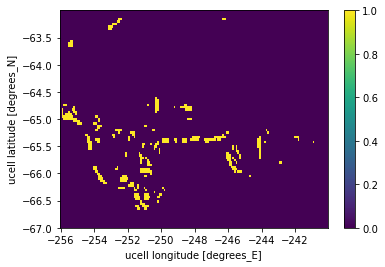

In [89]:
# I've used degrees of freedom = N_eff - 1.

# values from two-tailed t-distribution table:

# where N_eff < 6, critical value is 2.8, mask where t-statistic < 2.8
# where 6 < N_eff < 7, critical value is 2.6, mask where t-statistic < 2.6
# where 7 < N_eff < 8, critical value is 2.5, mask where t-statistic < 2.5
# where 8 < N_eff < 9, critical value is 2.4, mask where t-statistic < 2.4
# where 9 < N_eff < 11, critical value is 2.3, mask where t-statistic < 2.3
# where 11 < N_eff < 15, critical value is 2.2, mask where t-statistic < 2.2
# where 15 < N_eff < 29, critical value is 2.1, mask where t-statistic < 2.1
# where 29 < N_eff , critical value is 2.0, mask where t-statistic < 2.0

def compute_significance_mask(N_eff,t_statistic):
    ones = N_eff*0+1
    Neff6 = ones.where(N_eff<6,other=0).where(np.abs(t_statistic)>2.8,other=0)
    Neff7 = ones.where(N_eff>6,other=0).where(N_eff<7,other=0).where(np.abs(t_statistic)>2.6,other=0)
    Neff8 = ones.where(N_eff>7,other=0).where(N_eff<8,other=0).where(np.abs(t_statistic)>2.5,other=0)
    Neff9 = ones.where(N_eff>8,other=0).where(N_eff<9,other=0).where(np.abs(t_statistic)>2.4,other=0)
    Neff10 = ones.where(N_eff>9,other=0).where(N_eff<11,other=0).where(np.abs(t_statistic)>2.3,other=0)
    Neff11 = ones.where(N_eff>11,other=0).where(N_eff<15,other=0).where(np.abs(t_statistic)>2.2,other=0)
    Neff15 = ones.where(N_eff>15,other=0).where(N_eff<29,other=0).where(np.abs(t_statistic)>2.1,other=0)
    Neff29 = ones.where(N_eff>29,other=0).where(np.abs(t_statistic)>2.0,other=0)
    
    significance = Neff6 + Neff7 + Neff8 +  Neff9 + Neff10 + Neff11 + Neff15 + Neff29
    
    return(significance)

significance = compute_significance_mask(N_eff,t_statistic)
significance.plot()
significance = significance.load()

In [90]:
t_statistic_temp = t_statistic
significance_temp = significance


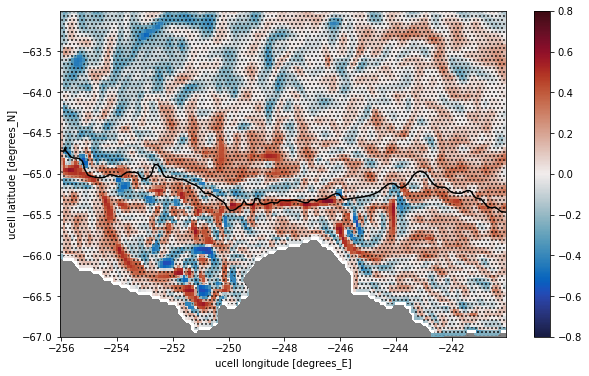

In [91]:
fig = plt.figure(figsize=(10,6))

cor_temp.plot(vmin=-.8,vmax=.8,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

# hatching where not significant:
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'k'
cs = plt.contourf(t_statistic_temp.xu_ocean,t_statistic_temp.yu_ocean,t_statistic_temp.where(significance_temp == 0),
                  colors='k',alpha=0.0,zorder=2,hatches=['...'])


#### asc hatch

In [92]:
## this is the cell from Adele's code for reference on how to adapt the two cells below
# Manually shift by 2 years, I don't think the lag in the code above is working:
#cov,temp_SWMT_correlation,temp_SWMT_slope,intercept,pval,stderr = lag_linregress_3D(rolling_mean_timeseries_IAF[2:-2].shift(year=2),temp_IAF_detrended)


In [93]:
temp_SWMT_correlation=cor_asc

# autocorrelation of spatial map of temperature:
cov,temp_autocorrelation,slope,intercept,pval,stderr = lag_linregress_3D(ekman_con_dr,ekman_con_dr)

# autocorrelation of SWMT:
cov,SWMT_autocorrelation,slope,intercept,pval,stderr = lag_linregress_3D(u_speed_tr[2:-2].shift(time=7),u_speed_tr[2:-2])

# original sample size:
N = len(u_speed_tr[2:-2])
    
# effective sample size for each lat/long location:
N_eff = N*(1-temp_autocorrelation*SWMT_autocorrelation)/(1+temp_autocorrelation*SWMT_autocorrelation)
N_eff = N_eff.load()

# compute t-statistic:
t_statistic = temp_SWMT_correlation*np.sqrt(N_eff)/(np.sqrt(1-temp_SWMT_correlation*temp_SWMT_correlation))
t_statistic = t_statistic.load()


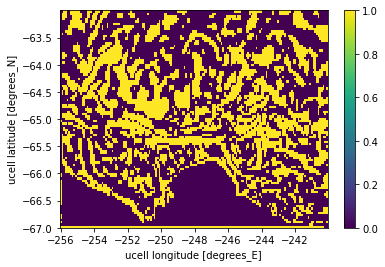

In [94]:
# I've used degrees of freedom = N_eff - 1.

# values from two-tailed t-distribution table:

# where N_eff < 6, critical value is 2.8, mask where t-statistic < 2.8
# where 6 < N_eff < 7, critical value is 2.6, mask where t-statistic < 2.6
# where 7 < N_eff < 8, critical value is 2.5, mask where t-statistic < 2.5
# where 8 < N_eff < 9, critical value is 2.4, mask where t-statistic < 2.4
# where 9 < N_eff < 11, critical value is 2.3, mask where t-statistic < 2.3
# where 11 < N_eff < 15, critical value is 2.2, mask where t-statistic < 2.2
# where 15 < N_eff < 29, critical value is 2.1, mask where t-statistic < 2.1
# where 29 < N_eff , critical value is 2.0, mask where t-statistic < 2.0

def compute_significance_mask(N_eff,t_statistic):
    ones = N_eff*0+1
    Neff6 = ones.where(N_eff<6,other=0).where(np.abs(t_statistic)>2.8,other=0)
    Neff7 = ones.where(N_eff>6,other=0).where(N_eff<7,other=0).where(np.abs(t_statistic)>2.6,other=0)
    Neff8 = ones.where(N_eff>7,other=0).where(N_eff<8,other=0).where(np.abs(t_statistic)>2.5,other=0)
    Neff9 = ones.where(N_eff>8,other=0).where(N_eff<9,other=0).where(np.abs(t_statistic)>2.4,other=0)
    Neff10 = ones.where(N_eff>9,other=0).where(N_eff<11,other=0).where(np.abs(t_statistic)>2.3,other=0)
    Neff11 = ones.where(N_eff>11,other=0).where(N_eff<15,other=0).where(np.abs(t_statistic)>2.2,other=0)
    Neff15 = ones.where(N_eff>15,other=0).where(N_eff<29,other=0).where(np.abs(t_statistic)>2.1,other=0)
    Neff29 = ones.where(N_eff>29,other=0).where(np.abs(t_statistic)>2.0,other=0)
    
    significance = Neff6 + Neff7 + Neff8 +  Neff9 + Neff10 + Neff11 + Neff15 + Neff29
    
    return(significance)

significance = compute_significance_mask(N_eff,t_statistic)
significance.plot()
significance = significance.load()

In [95]:
t_statistic_asc = t_statistic
significance_asc = significance


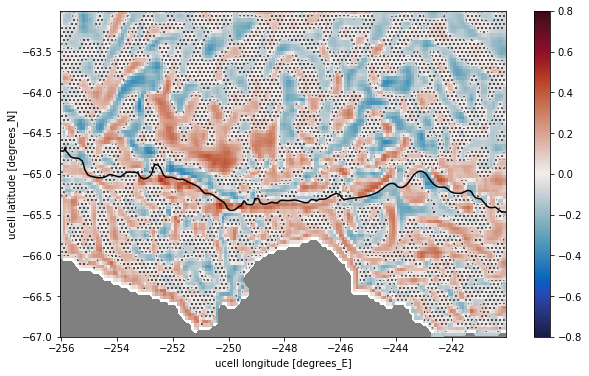

In [96]:
fig = plt.figure(figsize=(10,6))

cor_asc.plot(vmin=-.8,vmax=.8,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

# hatching where not significant:
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'k'
cs = plt.contourf(t_statistic_asc.xu_ocean,t_statistic_asc.yu_ocean,t_statistic_asc.where(significance_asc == 0),
                  colors='k',alpha=0.0,zorder=2,hatches=['...'])


### Loading Bathymetry for the plots

In [108]:
#have to load this again
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:zzzzzzzzzzzzzzzzzzzzzzzzz
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [109]:
#cor_temp

### LOAD SPECIAL CONTOURS

In [110]:
# cut the data BOX 1
lon_slice  = slice(-253, -251.5) #isopycnal contour
lat_slice  = slice(-67, -63)

# topography data:
ht2 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht2 = ht2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask2 = np.squeeze(ht2.values)*0
land_mask2[np.isnan(land_mask2)] = 1
land_mask2 = np.where(land_mask2==1,land_mask2,np.nan)

fontsize=16

In [111]:
# cut the data BOX 1
lon_slice  = slice(-251, -246) #ekman contour
lat_slice  = slice(-67, -63)

# topography data:
ht3 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht3 = ht3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask3 = np.squeeze(ht2.values)*0
land_mask3[np.isnan(land_mask3)] = 1
land_mask3 = np.where(land_mask3==1,land_mask3,np.nan)

fontsize=16


### PLOT THE SPATIAL CORR BETWEEN EKMAN AND ISO DEPTH

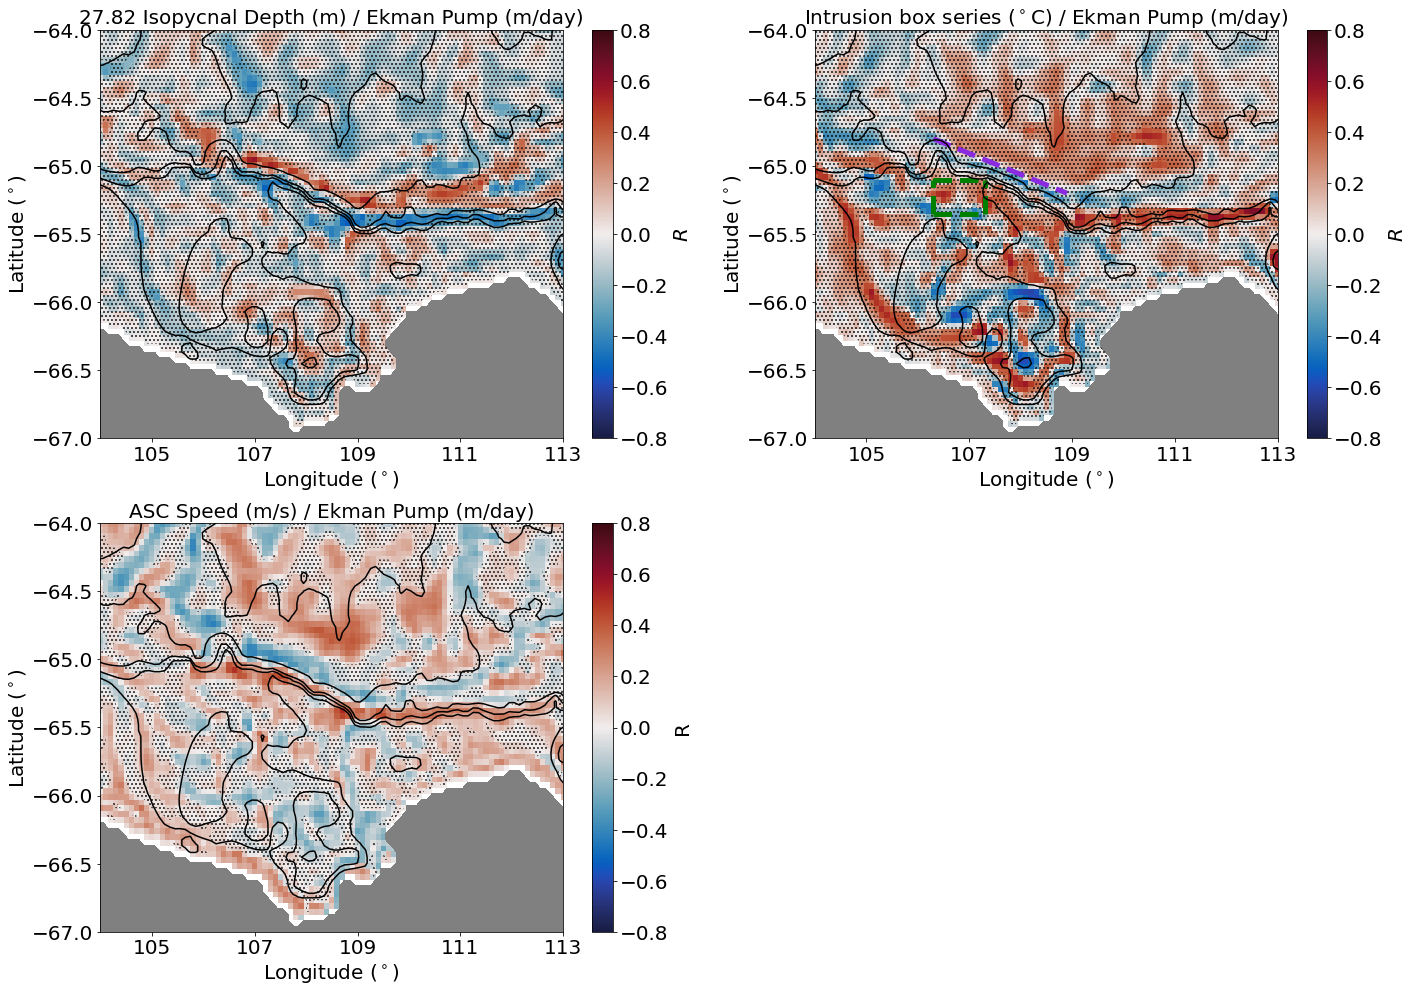

In [117]:
# Plot a map of the correlation at each point:
fontsize=20;
fig = plt.figure(figsize=(20,20))
ax1=plt.subplot(321) 
pc = plt.pcolormesh(cor_ekman.xu_ocean,cor_ekman.yu_ocean,
                        cor_ekman, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)

# hatching where not significant:
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'k'
cs = plt.contourf(t_statistic_ek.xu_ocean,t_statistic_ek.yu_ocean,t_statistic_ek.where(significance_ek == 0),
                  colors='k',alpha=0.0,zorder=2,hatches=['...'])

cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='blueviolet',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('27.82 Isopycnal Depth (m) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])

ax1=plt.subplot(322) 
pc = plt.pcolormesh(cor_temp.xu_ocean,cor_temp.yu_ocean,
                        cor_temp, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)

# hatching where not significant:
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'k'
cs = plt.contourf(t_statistic_temp.xu_ocean,t_statistic_temp.yu_ocean,t_statistic_temp.where(significance_temp == 0),
                  colors='k',alpha=0.0,zorder=2,hatches=['...'])

plt.plot([-252.7,-252.7],[-65.35, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=5)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('Intrusion box series ($^\circ$C) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])


ax1=plt.subplot(323) 
pc = plt.pcolormesh(cor_asc.xu_ocean,cor_asc.yu_ocean,
                        cor_asc, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)

# hatching where not significant:
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'k'
cs = plt.contourf(t_statistic_asc.xu_ocean,t_statistic_asc.yu_ocean,t_statistic_asc.where(significance_asc == 0),
                  colors='k',alpha=0.0,zorder=2,hatches=['...'])

cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.set_label('R',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='gray',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('ASC Speed (m/s) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/Fig5_ch4_spatialekman.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')



#### SAVING A FIG WITH THE CONTOURS WE NEED FOR INKSCAPE LATER

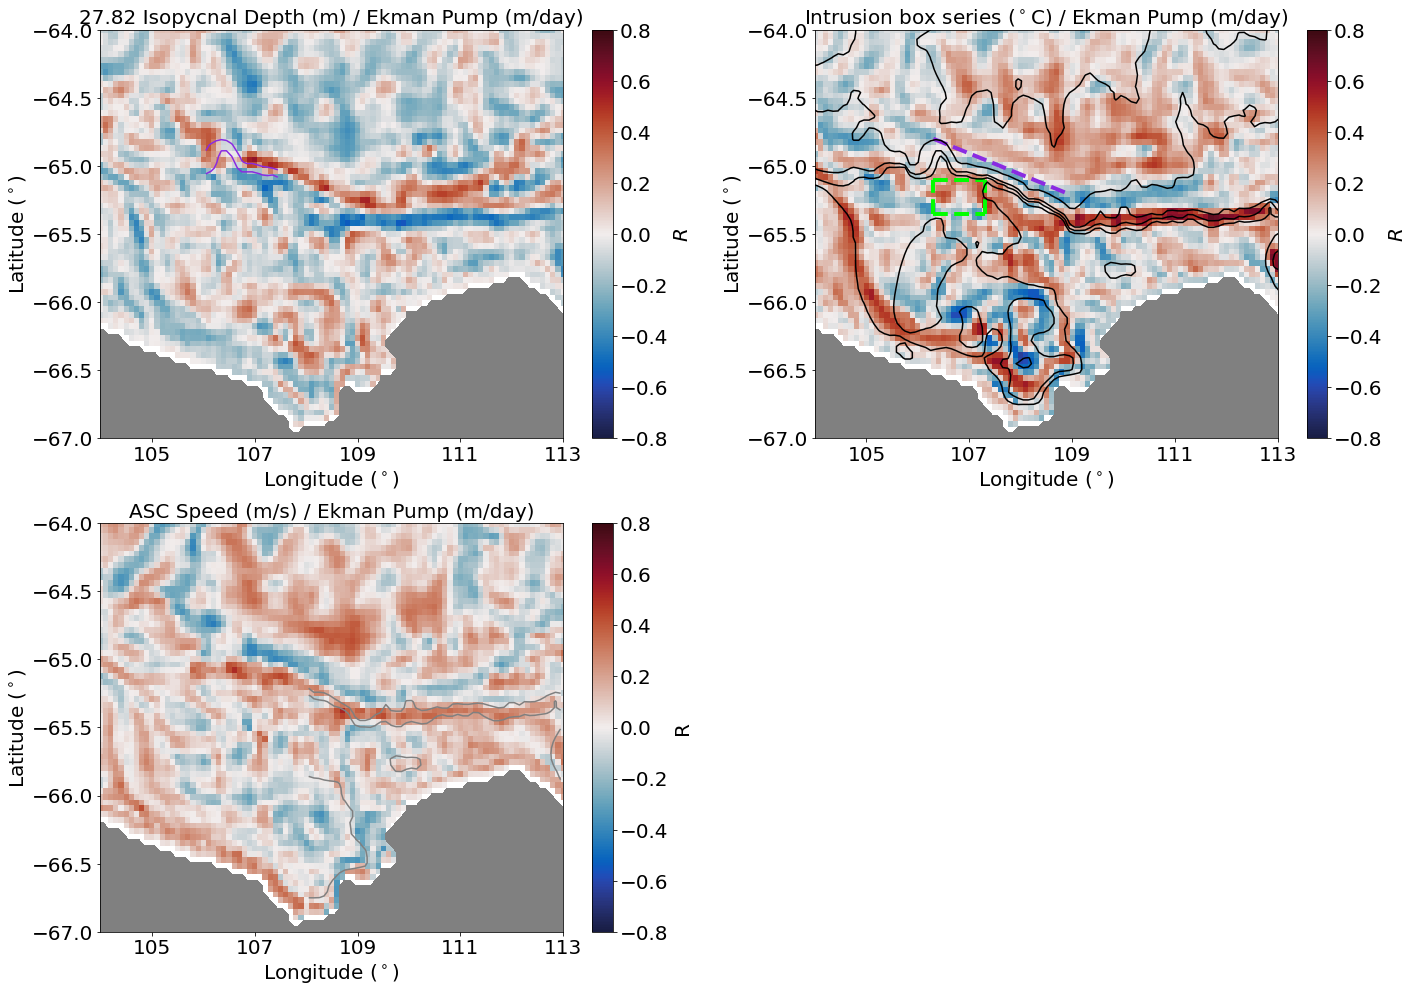

In [58]:
# Plot a map of the correlation at each point:
fontsize=20;
fig = plt.figure(figsize=(20,20))
ax1=plt.subplot(321) 
pc = plt.pcolormesh(cor_ekman.xu_ocean,cor_ekman.yu_ocean,
                        cor_ekman, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='blueviolet',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('27.82 Isopycnal Depth (m) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])

ax1=plt.subplot(322) 
pc = plt.pcolormesh(cor_temp.xu_ocean,cor_temp.yu_ocean,
                        cor_temp, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='lime',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='lime',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='lime',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='lime',linestyle='--',linewidth=4)
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('Intrusion box series ($^\circ$C) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])


ax1=plt.subplot(323) 
pc = plt.pcolormesh(cor_asc.xu_ocean,cor_asc.yu_ocean,
                        cor_asc, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.set_label('R',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht3.xt_ocean,ht3.yt_ocean,ht3,levels=[500,1000],colors='gray',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('ASC Speed (m/s) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
##figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/Fig5_ch4_spatialekman_rightcontours.eps'
plt.savefig(filestr,dpi=600,bbox_inches='tight')



In [49]:
pwd

'/home/581/ns3783/Scripts/Figures/New_codes_CFD'

[Text(-256.0, 0, '104'),
 Text(-254.0, 0, '105'),
 Text(-252.0, 0, '107'),
 Text(-250.0, 0, '109'),
 Text(-248.0, 0, '111'),
 Text(-246.0, 0, '113')]

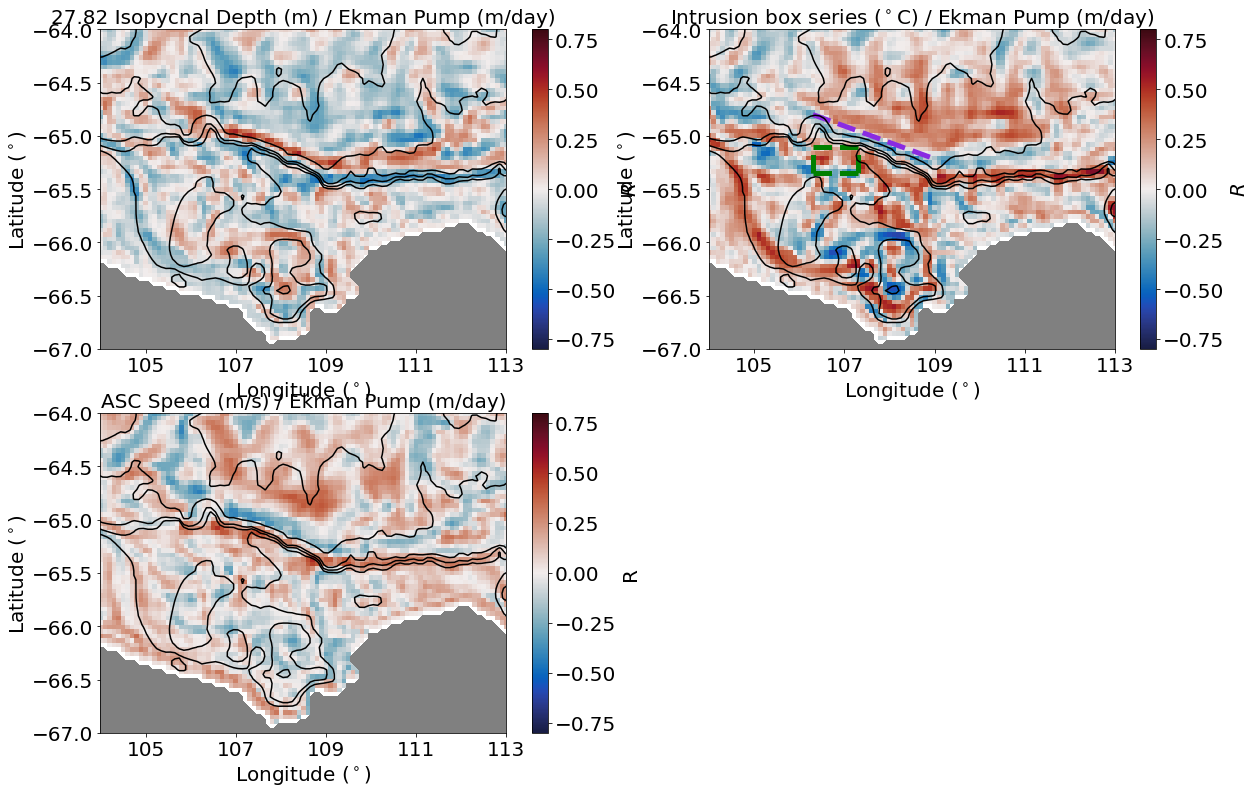

In [61]:
# Plot a map of the correlation at each point:
fontsize=20;
fig = plt.figure(figsize=(20,20))
ax1=plt.subplot(321) 
pc = plt.pcolormesh(cor_ekman.xu_ocean,cor_ekman.yu_ocean,
                        cor_ekman, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='blueviolet',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('27.82 Isopycnal Depth (m) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])

ax1=plt.subplot(322) 
pc = plt.pcolormesh(cor_temp.xu_ocean,cor_temp.yu_ocean,
                        cor_temp, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='green',linestyle='--',linewidth=5)
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=5)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
#cbar.ax.locator_params(nbins=8)
cbar.set_label('$R$',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('Intrusion box series ($^\circ$C) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])


ax1=plt.subplot(323) 
pc = plt.pcolormesh(cor_asc.xu_ocean,cor_asc.yu_ocean,
                        cor_asc, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.set_label('R',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='darkorange',linestyle='-',linewidth=3)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='gray',linewidth=1)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -246))
plt.ylabel('Latitude [$^\circ$S]')
plt.xlabel('Longitude [$^\circ$E]')
plt.title('ASC Speed (m/s) / Ekman Pump (m/day)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359,-247+359,-247+359,-246+359])
ax1.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

#fig.tight_layout()
#figdir = '/home/581/ns3783/Scripts/Figures/Current'
##figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/Fig5_ch4_spatialekman.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')


